In [2]:
%%capture
!pip install --upgrade pandas google-cloud-bigquery[pandas] six==1.13


In [ ]:
import six
import pandas as pd 
from google.cloud import bigquery

In [3]:
creds = {
  "type": "service_account",
  "project_id": "my-project-1563213739189",
  "client_email": "bq-sandbox@my-project-1563213739189.iam.gserviceaccount.com",
  "client_id": "102699358279752644267",
  "auth_uri": "https://accounts.google.com/o/oauth2/auth",
  "token_uri": "https://oauth2.googleapis.com/token",
  "auth_provider_x509_cert_url": "https://www.googleapis.com/oauth2/v1/certs",
  "client_x509_cert_url": "https://www.googleapis.com/robot/v1/metadata/x509/bq-sandbox%40my-project-1563213739189.iam.gserviceaccount.com"
}


In [7]:
from google_auth_oauthlib import flow 
appflow = flow.InstalledAppFlow.from_client_secrets_file(
'client_secrets.json',
scopes = ['https://www.googleapis.com/auth/bigquery'])
if launch_browser: 
    appflow_run_local_server()
else: 
    appflow.run_console()
    
credentials = appflow.credentials

NameError: name 'launch_browser' is not defined

In [8]:
appflow = flow.InstalledAppFlow.from_client_secrets_file(
    'client_secrets.json',
    scopes=['https://www.googleapis.com/auth/bigquery'])

In [10]:
creds = appflow.run_local_server()

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=852101288706-5jh5f21q27bf6oslm4jm76qaqdce0jgf.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=3k2X7U44hXpFw6XL7PYeITjnoAr1ho&access_type=offline


In [11]:
creds = appflow.credentials

In [12]:
from google.cloud import bigquery
project = 'my-project-1563213739189' # could use json dictionary from above 
client = bigquery.Client(project=project, credentials=creds)

In [13]:
query_string = """ SELECT name, SUM(number) as total 
FROM `bigquery-public-data.usa_names.usa_1910_current`
WHERE name = 'William'
GROUP BY name;
"""

query_job = client.query(query_string)
for row in query_job.result(): 
    print('{}-{}'.format(row['name'], row['total']))

William-3901134


## Getting data into a pandas df 

In [14]:
%%capture 
!pip install --upgrade google-cloud-bigquery[bqstorage, pandas]

In [15]:
%load_ext google.cloud.bigquery

In [21]:
s = """ 
SELECT * FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`;
"""

In [22]:
execute = client.query(s)
df = execute.result().to_dataframe()

In [23]:
s2 = '''select * from `bigquery-public-data.austin_bikeshare.bikeshare_stations`'''
ex = client.query(s2)
df2 = ex.result().to_dataframe()

### Exploratory data analysis 

In [24]:
df = df.dropna(subset = ['end_station_id'])

In [80]:
df = df.merge(df2[['station_id','latitude','longitude']].add_prefix('ending_'), left_on = 'end_station_id', right_on = 'ending_station_id')

In [82]:
df.to_csv('austin_bike_trips_intermediate.csv')

In [92]:
df.duration_minutes.describe()

count    1.166411e+06
mean     2.877973e+01
std      1.123899e+02
min      0.000000e+00
25%      6.000000e+00
50%      1.200000e+01
75%      2.600000e+01
max      3.423800e+04
Name: duration_minutes, dtype: float64

In [85]:
df.end_station_id.nunique()

95

### Compute distance matrix between all stations --> map in distance 

In [87]:
# Find nunique stations --> 95 
# Create matrix of all 95 stations, fill values by api call 
unique_stations = df.end_station_id.unique()


In [99]:
d_m = pd.DataFrame(index = unique_stations, columns = unique_stations)

In [102]:
d_m = d_m.fillna(0)

### Now that we have an empty dataframe, we need to map in the values 

In [6]:
# There are probably several ways to do this 
# We could concat the starting and ending stations to make the requests part easier to handle 

df.head()
df['start_coords'] = df['starting_latitude'].astype('str') + ',' + df['starting_longitude'].astype('str')
df['end_coords'] = df['ending_latitude'].astype('str') + ',' + df['ending_longitude'].astype('str')

In [7]:
trip_df = df[['start_station_name','end_station_name','start_coords','end_coords']]

In [8]:
trip_df = trip_df.drop_duplicates()

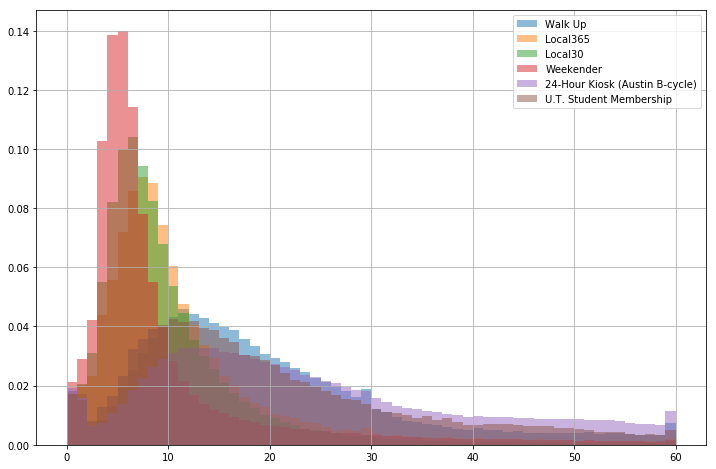

In [73]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
ax = df.groupby('subscriber_type')['duration_minutes'].hist(bins = np.arange(61), alpha = .5, density = True)
plt.legend([i for i in df.subscriber_type.unique()])

In [63]:
x = df.groupby('subscriber_type')['trip_id'].count().sort_values(ascending = False).iloc[:10]/len(df)

In [68]:
x.cumsum()

subscriber_type
Walk Up                               0.311145
U.T. Student Membership               0.545928
Local365                              0.708577
24-Hour Kiosk (Austin B-cycle)        0.786766
Local30                               0.839549
Weekender                             0.877863
Annual Membership (Austin B-cycle)    0.901778
Explorer                              0.919293
24 Hour Walk Up Pass                  0.932109
Local365+Guest Pass                   0.943621
Name: trip_id, dtype: float64

In [69]:
x.index[:6]

Index(['Walk Up', 'U.T. Student Membership', 'Local365',
       '24-Hour Kiosk (Austin B-cycle)', 'Local30', 'Weekender'],
      dtype='object', name='subscriber_type')

In [70]:
df = df.loc[df['subscriber_type'].isin(x.index[:6])]

import seaborn as sns 


top_stations = df.groupby("start_station_name").count().iloc[:20,0].sort_values(ascending = False).index

import matplotlib.pyplot as plt 

top_station_trips = df[df.start_station_name.isin(top_stations)]

from scipy import stats 

import numpy as np
df = df[np.abs(stats.zscore(df.duration_minutes) < 3).all(axis = 1)]

[Text(0, 0, '11th & San Jacinto'),
 Text(0, 0, '13th & San Antonio'),
 Text(0, 0, '10th & Red River'),
 Text(0, 0, '11th & Salina'),
 Text(0, 0, '11th & Salina '),
 Text(0, 0, '11th/Congress @ The Texas Capitol'),
 Text(0, 0, '22nd & Pearl'),
 Text(0, 0, '21st & University'),
 Text(0, 0, '21st & Speedway @PCL'),
 Text(0, 0, '17th & Guadalupe'),
 Text(0, 0, '11th/San Jacinto'),
 Text(0, 0, '10th/Red River'),
 Text(0, 0, '11th/Salina '),
 Text(0, 0, '21st/University'),
 Text(0, 0, '21st/Speedway @ PCL'),
 Text(0, 0, '22nd/Pearl'),
 Text(0, 0, '13th/San Antonio'),
 Text(0, 0, '17th/Guadalupe'),
 Text(0, 0, '21st/Guadalupe'),
 Text(0, 0, '12th/San Jacinto @ State Capitol Visitors Garage')]

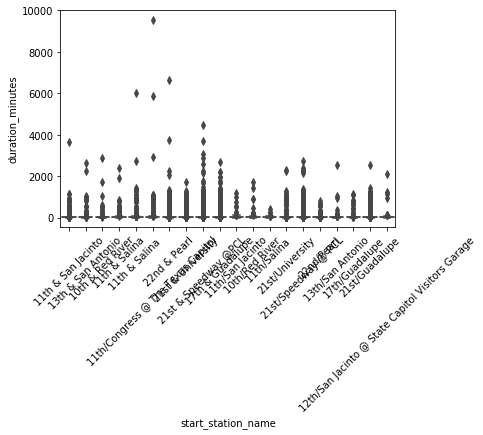

In [149]:
ax = sns.boxplot(y = 'duration_minutes', x = 'start_station_name', data = top_station_trips)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

### 

### 

In [1]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
df = pd.read_csv('austin_bike_trips_intermediate.csv')

In [12]:
trip_df['all_coords'] = trip_df['start_coords'] + '--' + trip_df['end_coords']
trip_df['all_coords'].nunique() # See how many unique trip destinations and endpoints there were 

7047

## Now we can try requests

In [24]:
trip_df.head()

,start_station_name,end_station_name,start_coords,end_coords,all_coords
0,Capital Metro HQ - East 5th at Broadway,East 6th & Pedernales St.,"30.2563,-97.71007","30.25895,-97.71475","30.2563,-97.71007--30.25895,-97.71475"
137,East 5th/Broadway @ Capital Metro HQ,East 6th/Pedernales,"30.2563,-97.71007","30.25895,-97.71475","30.2563,-97.71007--30.25895,-97.71475"
140,Zilker Park West,East 6th & Pedernales St.,"30.26587,-97.76826","30.25895,-97.71475","30.26587,-97.76826--30.25895,-97.71475"
142,Toomey Rd @ South Lamar,East 6th & Pedernales St.,"30.263040000000004,-97.75824","30.25895,-97.71475","30.263040000000004,-97.75824--30.25895,-97.71475"
151,State Capitol @ 14th & Colorado,East 6th & Pedernales St.,"30.27654,-97.74155","30.25895,-97.71475","30.27654,-97.74155--30.25895,-97.71475"


In [34]:
url = 'https://maps.googleapis.com/maps/api/distancematrix/json?'
origin, dest = "origins="  + trip_df['start_coords'].unique(), "&destinations=" + trip_df['end_coords'].unique()
r = url + origin + dest + "&units=imperial" + '&transit_mode=bicycling' "&key=" + api_key

### 

In [135]:
itr = zip(trip_df.start_coords.unique(), trip_df.end_coords.unique())

In [136]:
l = ["{}".format(lat, lon) for (lat, lon) in itr]

In [137]:
l

['30.2563,-97.71007',
 '30.26587,-97.76826',
 '30.263040000000004,-97.75824',
 '30.27654,-97.74155',
 '30.264609999999998,-97.73049',
 '30.268959999999996,-97.72843',
 '30.271929999999998,-97.73854',
 '30.26694,-97.74939',
 '30.25542,-97.71665',
 '30.27624,-97.74831',
 '30.258020000000002,-97.7391',
 '30.268890000000003,-97.74525',
 '30.27595,-97.74739',
 '30.269109999999998,-97.7462',
 '30.276159999999997,-97.74488000000001',
 '30.26455,-97.73165',
 '30.26025,-97.71002',
 '30.272170000000003,-97.75246',
 '30.27807,-97.77271999999999',
 '30.27024,-97.73578',
 '30.262690000000003,-97.72438000000001',
 '30.26888,-97.72431',
 '30.26969,-97.71873000000001',
 '30.26212,-97.73815',
 '30.266379999999998,-97.7214',
 '30.24472,-97.72336',
 '30.24258,-97.71726',
 '30.251890000000003,-97.73323',
 '30.270590000000002,-97.74441',
 '30.25495,-97.74755',
 '30.273359999999997,-97.73805',
 '30.26912,-97.73986',
 '30.26019,-97.73845',
 '30.264159999999997,-97.73289',
 '30.26735,-97.73933000000001',
 '30

In [139]:
test_response = requests.get(build_url(1)) 

In [156]:
stations = trip_df[['start_station_name','start_coords']]
stations = stations.drop_duplicates()


start_station_name    170
start_coords           95
dtype: int64

In [159]:
stations = stations.drop_duplicates('start_coords')

### Let's call the API and build the matrix 

In [188]:
import os 
os.makedirs('./dm_json_outputs', exist_ok = True)

In [192]:
stations['start_station_name'] = stations['start_station_name'].str.replace('/', '_')

In [193]:
for i in range(len(l) -1): 
    r = build_url(i)
    obj = requests.get(r).json()
    with open('./dm_json_outputs/{}_distances.json'.format(stations.iloc[i,0]), 'w') as out_file:
        out_file.write(json.dumps(obj))


### Build distance matrix from inputs

In [325]:
dist = np.zeros((len(stations), len(stations)), dtype = float)

for i, station in enumerate(stations.start_station_name): 
    try:
        filename = f"{station}_distances.json"
        row = json.load(open(filename))
        dist[i, i + 1:] = [el['distance']['value'] for el in row['rows'][0]['elements']]
    except: 
        pass

out = dist + dist.T

distances_final = pd.DataFrame(out, index = stations.start_station_name, columns = stations.start_station_name)

distance_df = distances_final

In [357]:
stacked = distance_df.stack()
stacked.name = 'distance'

In [353]:
stacked

start_station_name                       start_station_name                     
Capital Metro HQ - East 5th at Broadway  Capital Metro HQ - East 5th at Broadway       0.0
                                         Zilker Park West                           6991.0
                                         Toomey Rd @ South Lamar                    6452.0
                                         State Capitol @ 14th & Colorado            4535.0
                                         Waller & 6th St.                           2299.0
                                                                                     ...  
Main Office                              Republic Square                            1304.0
                                         6th & Navasota St.                         1793.0
                                         State Parking Garage @ Brazos & 18th       1197.0
                                         8th & Guadalupe                             987.0
         

In [358]:
df = df.join(stacked, on = ['start_station_name', 'end_station_name'])

In [360]:
df = df.drop(columns = ['Unnamed: 0', 'start_coords','end_coords'])

In [367]:
max(df['distance'] * 0.000621371)

6.055881766

In [370]:
max(df['distance'])

9746.0

(0, 6500)

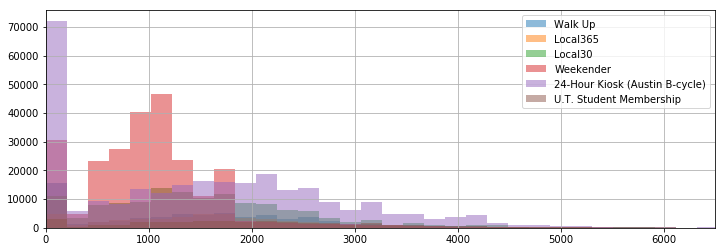

In [376]:
fig, ax = plt.subplots(figsize = (12,4))
df.groupby('subscriber_type')['distance'].hist(bins = np.linspace(0,10000, 50), alpha = .5)
plt.legend([i for i in df.subscriber_type.unique()])
ax.set_xlim(0, 6500)

In [386]:
rate_df = df.groupby('subscriber_type')[['duration_minutes', 'distance']].mean().sort_values('duration_minutes', ascending = False)

In [387]:
rate_df['rate'] = rate_df['distance'] / rate_df['duration_minutes']

In [388]:
rate_df['rate'] = rate_df['rate'] * 0.0372823

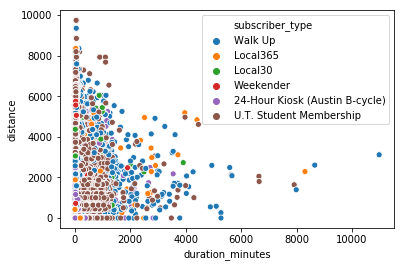

In [391]:
sns.scatterplot(df['duration_minutes'], df['distance'], hue = 'subscriber_type', data = df)

In [378]:
df.groupby('subscriber_type')['distance'].median()

subscriber_type
24-Hour Kiosk (Austin B-cycle)    1431.0
Local30                           1574.0
Local365                          1433.0
U.T. Student Membership           1003.0
Walk Up                           1464.0
Weekender                         1950.0
Name: distance, dtype: float64